In [ ]:
pip install boto3 mlflow==2.7.1

## Load the dataset

The following cells load a dataset containing weather data and power output information for a wind farm in the United States. 
The dataset contains wind direction, wind speed, and air temperature features sampled every eight hours (once at 00:00, once at 08:00, and once at 16:00), as well as daily aggregate power output (power), over several years.

In [1]:
# Load the dataset

import pandas as pd
wind_farm_data = pd.read_csv("https://github.com/dbczumar/model-registry-demo-notebook/raw/master/dataset/windfarm_data.csv", index_col=0)
 
def get_training_data():
  training_data = pd.DataFrame(wind_farm_data["2014-01-01":"2018-01-01"])
  X = training_data.drop(columns="power")
  y = training_data["power"]
  return X, y
 
def get_validation_data():
  validation_data = pd.DataFrame(wind_farm_data["2018-01-01":"2019-01-01"])
  X = validation_data.drop(columns="power")
  y = validation_data["power"]
  return X, y
 
def get_weather_and_forecast():
  format_date = lambda pd_date : pd_date.date().strftime("%Y-%m-%d")
  today = pd.Timestamp('today').normalize()
  week_ago = today - pd.Timedelta(days=5)
  week_later = today + pd.Timedelta(days=5)
  
  past_power_output = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(today)]
  weather_and_forecast = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(week_later)]
  if len(weather_and_forecast) < 10:
    past_power_output = pd.DataFrame(wind_farm_data).iloc[-10:-5]
    weather_and_forecast = pd.DataFrame(wind_farm_data).iloc[-10:]
 
  return weather_and_forecast.drop(columns="power"), past_power_output["power"]

In [2]:
# Display a sample of the data for reference.

wind_farm_data["2019-01-01":"2019-01-14"]

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2019-01-01,8.875944,97.246960,11.665322,11.955358,98.636955,12.240791,14.668171,112.411930,9.737414,8509.6200
2019-01-02,15.183593,150.793730,10.765375,11.806581,202.014570,5.050459,8.744499,299.835420,6.469718,3876.5240
2019-01-03,5.572408,278.278230,2.968834,8.377396,98.699100,7.120559,9.474814,200.089770,1.316572,1511.1980
2019-01-04,7.883471,83.243490,1.943103,10.387258,147.142290,2.183379,10.536873,318.377930,2.621120,256.9488
2019-01-05,8.764894,305.704250,5.041509,8.271966,291.500180,4.422956,7.382129,113.804474,4.078743,1014.6314
2019-01-06,5.438333,106.043320,5.787299,7.966585,139.703280,2.067099,6.946286,285.241820,2.774709,859.2375
2019-01-07,4.202758,207.217350,2.983574,6.853256,112.100510,7.334027,8.428836,112.508860,9.337582,3766.5713
2019-01-08,7.556848,106.699104,9.850532,9.393202,100.567024,10.189929,10.031277,99.752014,8.621423,6999.7627
2019-01-09,7.387094,98.269590,8.638614,9.839335,98.169464,8.310448,10.385242,102.197290,3.762180,3924.3154
2019-01-10,7.586321,213.040680,1.303631,9.785772,91.479225,3.234444,9.988096,110.400520,7.184761,1593.0924


## Train a power forecasting model and track it with MLflow

The following cells train a neural network to predict power output based on the weather features in the dataset. MLflow is used to track the model's hyperparameters, performance metrics, source code, and artifacts.

In [3]:
# Define a power forecasting model using TensorFlow Keras.

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


def train_keras_model(X, y):
  
  model = Sequential()
  model.add(Dense(100, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
 
  model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=.2)
  return model



2023-09-20 10:33:11.932962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-20 10:33:11.932994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
# Train the model and use MLflow to track its parameters, metrics, artifacts, and source code.

import mlflow
import mlflow.keras
import mlflow.tensorflow
import os

os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://minio-service.kubeflow.svc.cluster.local:9000" 

X_train, y_train = get_training_data()

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000/")
mlflow.set_experiment("power-forecasting-model")
experiment = mlflow.get_experiment_by_name("power-forecasting-model")

with mlflow.start_run(experiment_id=experiment.experiment_id):
  # Automatically capture the model's parameters, metrics, artifacts,
  # and source code with the `autolog()` function
  mlflow.tensorflow.autolog()
  train_keras_model(X_train, y_train)
  run_id = mlflow.active_run().info.run_id

2023/09/20 10:53:36 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 10128366.0000 - val_loss: 7843958.0000
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 9667461.0000 - val_loss: 7399838.0000
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 9151164.0000 - val_loss: 6880089.0000
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 8526705.0000 - val_loss: 6302561.5000
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 7843390.0000 - val_loss: 5702880.5000
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 7155458.0000 - val_loss: 5161957.0000
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 6523151.5000 - val_loss: 4765026.0000
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 6037456.0000 - val_loss: 4547219.0000
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 5725814.0000 - val_loss: 4490135.0000


2023/09/20 10:53:40 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/09/20 10:53:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpdq_p8zno/model/data/model/assets


## Register the model with the MLflow Model Registry API
Now that a forecasting model has been trained and tracked with MLflow, the next step is to register it with the MLflow Model Registry. You can register and manage models using the MLflow UI or the MLflow API .

The following cells use the API to register your forecasting model, add rich model descriptions, and perform stage transitions. See the documentation for the UI workflow.

In [18]:
model_name = "power-forecasting-model" # Replace this with the name of your registered model, if necessary.
print(run_id)

54290f7e76764e72a436dc17990f24fa


### Create a new registered model using the API
The following cells use the mlflow.register_model() function to create a new registered model whose name begins with the string power-forecasting-model. This also creates a new model version (for example, Version 1 of power-forecasting-model).

In [19]:
import mlflow
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
mlflow.set_experiment("power-forecasting-model")
experiment = mlflow.get_experiment_by_name("power-forecasting-model")
# The default path where the MLflow autologging function stores the model
artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)
 
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)


Registered model 'power-forecasting-model' already exists. Creating a new version of this model...
2023/09/20 10:58:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: power-forecasting-model, version 5
Created version '5' of model 'power-forecasting-model'.


After creating a model version, it may take a short period of time to become ready. Certain operations, such as model stage transitions, require the model to be in the READY state. Other operations, such as adding a description or fetching model details, can be performed before the model version is ready (for example, while it is in the PENDING_REGISTRATION state).

The following cell uses the MlflowClient.get_model_version() function to wait until the model is ready.

In [20]:
import time
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")

def wait_until_ready(model_name, model_version):
  client = MlflowClient()
  for _ in range(10):
    model_version_details = client.get_model_version(
      name=model_name,
      version=model_version,
    )
    status = ModelVersionStatus.from_string(model_version_details.status)
    print("Model status: %s" % ModelVersionStatus.to_string(status))
    if status == ModelVersionStatus.READY:
      break
    time.sleep(1)
  
wait_until_ready(model_details.name, model_details.version)

Model status: READY


### Add model descriptions
You can add descriptions to registered models as well as model versions:
- Model version descriptions are useful for detailing the unique attributes of a particular model version (such as the methodology and algorithm used to develop the model).
- Registered model descriptions are useful for recording information that applies to multiple model versions (such as a general overview of the modeling problem and dataset).

In [21]:
# Add a high-level description to the registered model, including the machine learning problem and dataset.

from mlflow.tracking.client import MlflowClient

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This model forecasts the power output of a wind farm based on weather data. The weather data consists of three features: wind speed, wind direction, and air temperature."
)

<RegisteredModel: aliases={}, creation_timestamp=1694902964930, description=('This model forecasts the power output of a wind farm based on weather data. '
 'The weather data consists of three features: wind speed, wind direction, and '
 'air temperature.'), last_updated_timestamp=1695207499036, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1695206038434, current_stage='Production', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1695206082041, name='power-forecasting-model', run_id='a011f1ce388a48dba366e403f0ffa36c', run_link='', source='s3://mlpipeline/2/a011f1ce388a48dba366e403f0ffa36c/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='3'>,
 <ModelVersion: aliases=[], creation_timestamp=1695207484872, current_stage='None', description='', last_updated_timestamp=1695207484872, name='power-forecasting-model', run_id='54290f7e76764

In [22]:
# Add a model version description with information about the model architecture and machine learning framework.
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
client.update_model_version(
  name=model_details.name,
  version=model_details.version,
  description="This model version was built using TensorFlow Keras. It is a feed-forward neural network with one hidden layer."
)

<ModelVersion: aliases=[], creation_timestamp=1695207484872, current_stage='None', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1695207500271, name='power-forecasting-model', run_id='54290f7e76764e72a436dc17990f24fa', run_link='', source='s3://mlpipeline/2/54290f7e76764e72a436dc17990f24fa/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='5'>

## Perform a model stage transition
The MLflow Model Registry defines several model stages: None, Staging, Production, and Archived. Each stage has a unique meaning. For example, Staging is meant for model testing, while Production is for models that have completed the testing or review processes and have been deployed to applications.

Users with appropriate permissions can transition models between stages. In private preview, any user can transition a model to any stage. In the near future, administrators in your organization will be able to control these permissions on a per-user and per-model basis.

If you have permission to transition a model to a particular stage, you can make the transition directly by using the MlflowClient.update_model_version() function. If you do not have permission, you can request a stage transition using the REST API; for example:
    
```bash
%sh curl -i -X POST -H "X-Databricks-Org-Id: <YOUR_ORG_ID>" -H "Authorization: Bearer <YOUR_ACCESS_TOKEN>" https://<YOUR_DATABRICKS_WORKSPACE_URL>/api/2.0/preview/mlflow/transition-requests/create -d '{"comment": "Please move this model into production!", "model_version": {"version": 1, "registered_model": {"name": "power-forecasting-model"}}, "stage": "Production"}'
```

In [23]:
# Now that you've learned about stage transitions, transition the model to the Production stage.
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Production',
)

<ModelVersion: aliases=[], creation_timestamp=1695207484872, current_stage='Production', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1695207503240, name='power-forecasting-model', run_id='54290f7e76764e72a436dc17990f24fa', run_link='', source='s3://mlpipeline/2/54290f7e76764e72a436dc17990f24fa/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='5'>

In [24]:
# Use the MlflowClient.get_model_version() function to fetch the model's current stage.
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
model_version_details = client.get_model_version(
  name=model_details.name,
  version=model_details.version,
)
print("The current model stage is: '{stage}'".format(stage=model_version_details.current_stage))


The current model stage is: 'Production'


The MLflow Model Registry allows multiple model versions to share the same stage. When referencing a model by stage, the Model Registry will use the latest model version (the model version with the largest version ID). The MlflowClient.get_latest_versions() function fetches the latest model version for a given stage or set of stages. The following cell uses this function to print the latest version of the power forecasting model that is in the Production stage.

In [25]:
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
latest_version_info = client.get_latest_versions(model_name, stages=["Production"])
latest_production_version = latest_version_info[0].version
print("The latest production version of the model '%s' is '%s'." % (model_name, latest_production_version))

The latest production version of the model 'power-forecasting-model' is '5'.


## Integrate the model with the forecasting application
Now that you have trained and registered a power forecasting model with the MLflow Model Registry, the next step is to integrate it with an application. This application fetches a weather forecast for the wind farm over the next five days and uses the model to produce power forecasts. For example purposes, the application consists of a simple forecast_power() function (defined below) that is executed within this notebook. In practice, you may want to execute this function as a recurring batch inference job using the Databricks Jobs service.

The following section demonstrates how to load model versions from the MLflow Model Registry for use in applications. The Forecast power output with the production model section uses the Production model to forecast power output for the next five days.

### Load versions of the registered model
The MLflow Models component defines functions for loading models from several machine learning frameworks. For example, mlflow.tensorflow.load_model() is used to load Tensorflow Keras models that were saved in MLflow format, and mlflow.sklearn.load_model() is used to load scikit-learn models that were saved in MLflow format.

These functions can load models from the MLflow Model Registry.

You can load a model by specifying its name (for example, power-forecast-model) and version number (in this case, 1). The following cell uses the mlflow.pyfunc.load_model() API to load Version 1 of the registered power forecasting model as a generic Python function.

In [28]:
import mlflow.pyfunc
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
model_version_uri = "models:/{model_name}/latest".format(model_name=model_name)
 
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_1 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/power-forecasting-model/latest'


In [29]:
# You can also load a specific model stage. The following cell loads the Production stage of the power forecasting model.

model_production_uri = "models:/{model_name}/production".format(model_name=model_name)
 
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_production_uri))
model_production = mlflow.pyfunc.load_model(model_production_uri)

Loading registered model version from URI: 'models:/power-forecasting-model/production'


### Forecast power output with the production model
In this section, the production model is used to evaluate weather forecast data for the wind farm. The forecast_power() application loads the latest version of the forecasting model from the specified stage and uses it to forecast power production over the next five days.

1/1 [==============================] - 0s 66ms/step
                      0
2020-12-22  1922.463867
2020-12-23  2409.332520
2020-12-24  3562.672363
2020-12-25  4642.556641
2020-12-26  4371.518066
2020-12-27  2748.984375
2020-12-28  3908.730225
2020-12-29  5431.390137
2020-12-30  3193.470215
2020-12-31  2196.693604


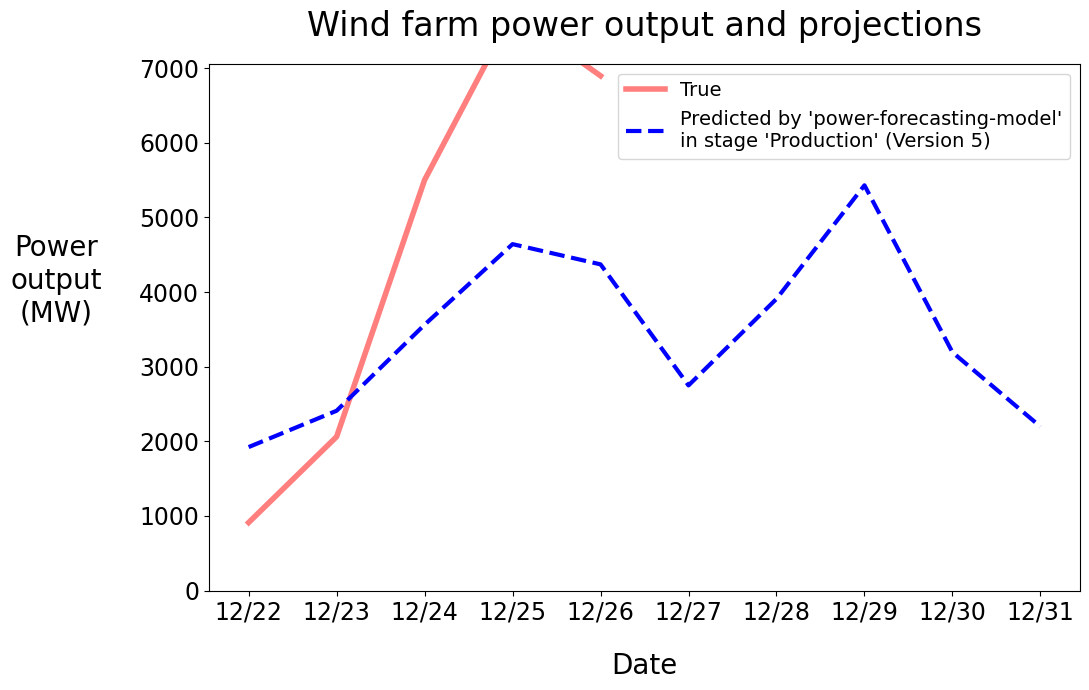

None

In [30]:
def plot(model_name, model_stage, model_version, power_predictions, past_power_output):
  import pandas as pd
  import matplotlib.dates as mdates
  from matplotlib import pyplot as plt
  index = power_predictions.index
  fig = plt.figure(figsize=(11, 7))
  ax = fig.add_subplot(111)
  ax.set_xlabel("Date", size=20, labelpad=20)
  ax.set_ylabel("Power\noutput\n(MW)", size=20, labelpad=60, rotation=0)
  ax.tick_params(axis='both', which='major', labelsize=17)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
  ax.plot(index[:len(past_power_output)], past_power_output, label="True", color="red", alpha=0.5, linewidth=4)
  ax.plot(index, power_predictions.squeeze(), "--", label="Predicted by '%s'\nin stage '%s' (Version %d)" % (model_name, model_stage, model_version), color="blue", linewidth=3)
  ax.set_ylim(ymin=0, ymax=max(3500, int(max(power_predictions.values) * 1.3)))
  ax.legend(fontsize=14)
  plt.title("Wind farm power output and projections", size=24, pad=20)
  plt.tight_layout()
  display(plt.show())

def forecast_power(model_name, model_stage):
  from mlflow.tracking.client import MlflowClient
  client = MlflowClient()
  model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version
  model_uri = "models:/{model_name}/{model_stage}".format(model_name=model_name, model_stage=model_stage)
  model = mlflow.pyfunc.load_model(model_uri)
  weather_data, past_power_output = get_weather_and_forecast()
  power_predictions = pd.DataFrame(model.predict(weather_data))
  power_predictions.index = pd.to_datetime(weather_data.index)
  print(power_predictions)
  plot(model_name, model_stage, int(model_version), power_predictions, past_power_output)
    
forecast_power(model_name, "Production")

### Create and deploy a new model version
The MLflow Model Registry enables you to create multiple model versions corresponding to a single registered model. By performing stage transitions, you can seamlessly integrate new model versions into your staging or production environments. Model versions can be trained in different machine learning frameworks (such as scikit-learn and tensorflow); MLflow's python_function provides a consistent inference API across machine learning frameworks, ensuring that the same application code continues to work when a new model version is introduced.

The following sections create a new version of the power forecasting model using scikit-learn, perform model testing in Staging, and update the production application by transitioning the new model version to Production.

In [31]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")

with mlflow.start_run():
  n_estimators = 300
  mlflow.log_param("n_estimators", n_estimators)
  
  rand_forest = RandomForestRegressor(n_estimators=n_estimators)
  rand_forest.fit(X_train, y_train)
 
  val_x, val_y = get_validation_data()
  mse = mean_squared_error(rand_forest.predict(val_x), val_y)
  print("Validation MSE: %d" % mse)
  mlflow.log_metric("mse", mse)
  
  # Specify the `registered_model_name` parameter of the `mlflow.sklearn.log_model()`
  # function to register the model with the MLflow Model Registry. This automatically
  # creates a new model version
  mlflow.sklearn.log_model(
    sk_model=rand_forest,
    artifact_path="sklearn-model",
    registered_model_name=model_name,
  )


Validation MSE: 44058


Registered model 'power-forecasting-model' already exists. Creating a new version of this model...
2023/09/20 10:59:24 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: power-forecasting-model, version 6
Created version '6' of model 'power-forecasting-model'.


### Fetch the new model version ID using MLflow Model Registry Search
The MlflowClient.search_model_versions() function searches for model versions by model name, MLflow run ID, or artifact source location. All model versions satisfying a particular filter query are returned.

The following cell uses this search function to fetch the version ID of the new model. It searches for the maximum value of the version ID (that is, the most recent version).

In [32]:
from mlflow.tracking.client import MlflowClient
client = MlflowClient()
 
model_version_infos = client.search_model_versions("name = '%s'" % model_name)
new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

# Wait for the new model version to become ready.
wait_until_ready(model_name, new_model_version)

Model status: READY


In [33]:
### Add a description to the new model version

client.update_model_version(
  name=model_name,
  version=new_model_version,
  description="This model version is a random forest containing 100 decision trees that was trained in scikit-learn."
)

<ModelVersion: aliases=[], creation_timestamp=1695207564052, current_stage='None', description=('This model version is a random forest containing 100 decision trees that was '
 'trained in scikit-learn.'), last_updated_timestamp=1695207567771, name='power-forecasting-model', run_id='856b3d17e9de49b698e201ab86c1f3ca', run_link='', source='s3://mlpipeline/2/856b3d17e9de49b698e201ab86c1f3ca/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='', version='6'>

### Transition the new model version to Staging
Before deploying a model to a production application, it is often best practice to test it in a staging environment. The following cells transition the new model version to Staging and evaluate its performance.

In [34]:
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version,
  stage="Staging",
)

<ModelVersion: aliases=[], creation_timestamp=1695207564052, current_stage='Staging', description=('This model version is a random forest containing 100 decision trees that was '
 'trained in scikit-learn.'), last_updated_timestamp=1695207643106, name='power-forecasting-model', run_id='856b3d17e9de49b698e201ab86c1f3ca', run_link='', source='s3://mlpipeline/2/856b3d17e9de49b698e201ab86c1f3ca/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='', version='6'>

                      0
2020-12-22  1194.834926
2020-12-23  2322.264644
2020-12-24  5333.707464
2020-12-25  7691.117400
2020-12-26  6968.190433
2020-12-27  2773.333593
2020-12-28  5098.513780
2020-12-29  8715.280557
2020-12-30  3806.496281
2020-12-31  1431.886419


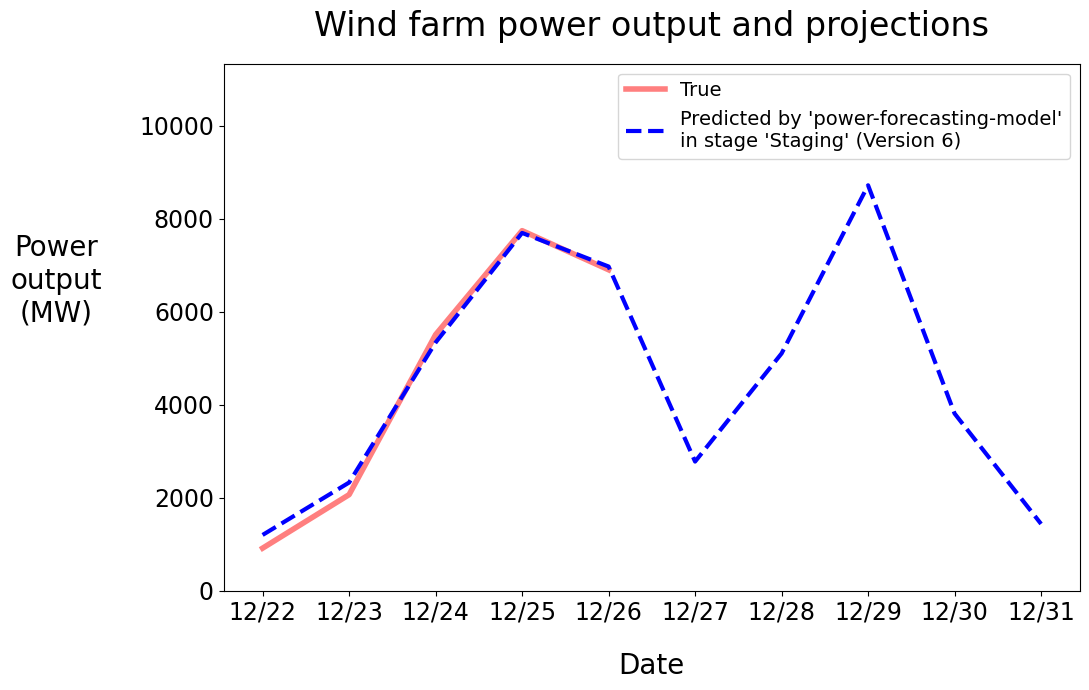

None

In [35]:
# Evaluate the new model's forecasting performance in Staging

forecast_power(model_name, "Staging")

## Transition the new model version to Production
After verifying that the new model version performs well in staging, the following cells transition the model version to Production and use the exact same application code from the Forecast power output with the production model section to produce a power forecast.

There are now two model versions of the forecasting model in the Production stage: the model version trained in Tensorflow Keras and the version trained in scikit-learn.

When referencing a model by stage, the MLflow Model Model Registry automatically uses the latest production version. This enables you to update your production models without changing any application code.

See the documentation for how to transition the model to Production using the UI.

In [ ]:
## Transition the new model version to Production using the API
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version,
  stage="Production",
)

In [ ]:
forecast_power(model_name, "Production")

### Archive and delete models
When a model version is no longer being used, you can archive it or delete it. You can also delete an entire registered model; this removes all of its associated model versions.

In [ ]:
# Archive Version 5

from mlflow.tracking.client import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=5,
  stage="Archived",
)

### Delete Version 1 of the power forecasting model
You can also use the MLflow UI or MLflow API to delete model versions. Model version deletion is permanent and cannot be undone.

The following cells provide a reference for deleting Version 5 of the power forecasting model using the MLflow API. See the documentation for how to delete a model version using the UI.

In [ ]:
client.delete_model_version(
 name=model_name,
 version=5,
)

### Delete the power forecasting model
If you want to delete an entire registered model, including all of its model versions, you can use the MlflowClient.delete_registered_model() to do so. This action cannot be undone. You must first transition all model version stages to None or Archived.

Warning: The following cell permanently deletes the power forecasting model, including all of its versions.

In [ ]:
client.transition_model_version_stage(
  name=model_name,
  version=6,
  stage="Archived"
)
 
# client.delete_registered_model(name=model_name)